# Notebook Count/TFIDF - Chi2 - ML

## Imports et chargemement des données

In [1]:
## for data
import json
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt

## for processing
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection

# machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import sklearn.metrics as metrics
import seaborn as sns

data = pd.read_json('../Data/data.json')
category = pd.read_csv('../Data/categories_string.csv')
label = pd.read_csv('../Data/label.csv')

data.head()

,Id,description,gender
0,0,She is also a Ronald D. Asmus Policy Entrepre...,F
1,1,He is a member of the AICPA and WICPA. Brent ...,M
10,8,Her teachings get straight to the heart of Ta...,F
100,80,"She founded Couples Therapy Inc, where she pr...",F
1000,780,He is the head of the Christian Doppler Labor...,M


## Création d'une nouvelle colonne dans le dataset correspondant à l'id de la catégorie de poste

On visualise les données dans les fichiers `data.json` et `categories_string.csv`.

In [2]:
data.head(10)

,Id,description,gender
0,0,She is also a Ronald D. Asmus Policy Entrepre...,F
1,1,He is a member of the AICPA and WICPA. Brent ...,M
10,8,Her teachings get straight to the heart of Ta...,F
100,80,"She founded Couples Therapy Inc, where she pr...",F
1000,780,He is the head of the Christian Doppler Labor...,M
10000,8015,She has worked in the field of disaster manag...,F
100000,80026,"She is a columnist for Russian Forbes, a free...",F
100003,80027,His patients gave him an average rating of 2....,M
100004,80028,Dr. Grunewald's areas of expertise consist of...,M
100005,80029,These areas are among Dr. Ennis's clinical in...,M


In [3]:
label.head(10)

,Id,Category
0,0,19
1,1,9
2,2,19
3,3,24
4,4,24
5,5,22
6,6,6
7,7,6
8,8,3
9,9,14


Les deux jeux de données sont liés par la colonne `Id`.  

On peut donc réaliser un merge des deux à partir des valeurs de cette colonne.

In [4]:
data = pd.merge(data, label, how="right", on="Id")
data.head(10)

,Id,description,gender,Category
0,0,She is also a Ronald D. Asmus Policy Entrepre...,F,19
1,1,He is a member of the AICPA and WICPA. Brent ...,M,9
2,8,Her teachings get straight to the heart of Ta...,F,3
3,80,"She founded Couples Therapy Inc, where she pr...",F,22
4,780,He is the head of the Christian Doppler Labor...,M,19
5,8015,She has worked in the field of disaster manag...,F,19
6,80026,"She is a columnist for Russian Forbes, a free...",F,6
7,80027,His patients gave him an average rating of 2....,M,11
8,80028,Dr. Grunewald's areas of expertise consist of...,M,11
9,80029,These areas are among Dr. Ennis's clinical in...,M,11


## Récupération d'une partie des données du dataset

Pour des raisons de ressources disponibles sur les machines (local ou AWS), on récupère une petite partie des données (ici, 10%).

In [5]:
data, data_other_part, y_studied_part, y_other_part = train_test_split(data, data["Category"], train_size=0.1, random_state=211101)
data.head(10)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,Id,description,gender,Category
186425,52315,He joined the documentary and photojournalism...,M,20
106264,1728,He moved to California in the year of 2000 to...,M,12
51484,126347,She holds a bachelor’s degree in Information ...,F,19
80136,152121,She earned her PhD from the Feinberg School o...,F,11
139681,205749,"Currently, her work is focused on dual orient...",F,19
90235,161231,He spent 15 years in the Army and Marine Corp...,M,4
142212,208032,In 1996 he founded the agency N2 architekten....,M,24
178441,45135,He is active in the American Association of P...,M,19
21710,99535,She has consulted with a variety of U.S. busi...,F,19
68615,141762,Prior to his faculty appointment at the Leigh...,M,19


On vérifie la distribution des données à l'aide du graphique suivant:

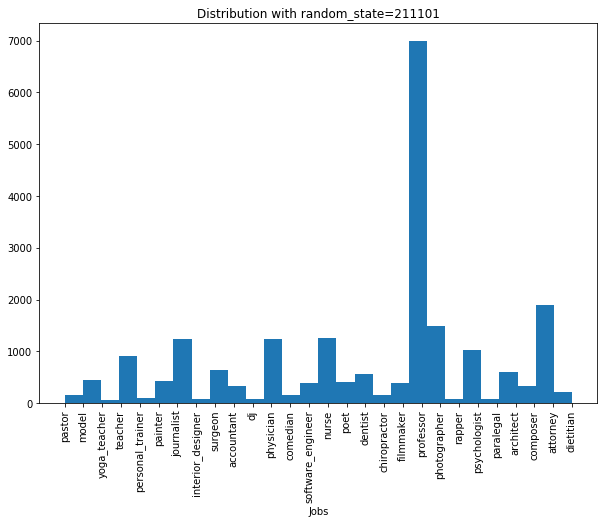

In [6]:
plt.figure(figsize=(10, 7))
plt.hist(data['Category'], 28)
plt.title("Distribution with random_state=211101")
plt.xlabel("Jobs")
plt.xticks(ticks = range(28), labels = category['0'], rotation = 'vertical')
plt.show()

On s'aperçoit que toutes les classes sont bien représentées.

## Préprocessing des extraits de CV

On crée une méthode permettant le préprocessing des extraits de CV. 

In [7]:
'''
Preprocess a CV extract
:parameter
    :param text: string - CV extract
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
    :param number: bool - whether number removal is to be applied
    :param lst_stopwords: list - list of stopwords to remove
:return
    cleaned CV extract
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, number=True, lst_stopwords=None):
    ## clean --> convert to lowercase and remove punctuations and characters and then strip
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    ## remove number in the text
    if number == True:
        text = re.sub('[0-9]+', '', text)
            
    ## convert from string to list
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.SnowballStemmer("english")
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

On récupère la liste de stopwords du module `nltk`.

In [8]:
nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


On applique la fonction de préprocessing à la liste des extraits de CV. Le retour de la fonction est stocké dans une nouvelle colonne : `description_clean`.

In [9]:
nltk.download('wordnet')
data_clean = data
data_clean["description_clean"] = data_clean["description"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, number=True, lst_stopwords=lst_stopwords))
data_clean.head()

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Id,description,gender,Category,description_clean
186425,52315,He joined the documentary and photojournalism...,M,20,joined documentary photojournalism one year pr...
106264,1728,He moved to California in the year of 2000 to...,M,12,moved california year pursue career world tele...
51484,126347,She holds a bachelor’s degree in Information ...,F,19,hold bachelor degree information system master...
80136,152121,She earned her PhD from the Feinberg School o...,F,11,earned phd feinberg school medicine northweste...
139681,205749,"Currently, her work is focused on dual orient...",F,19,currently work focused dual oriented bacterial...


## Première Vectorisation avec Count et TF-IDF
### Vectorizer Count
On applique le vectorizer `Count`. Il est basé sur la fréquence des mots.  

Cependant, cette méthode est peu utilisée, car un mot peut être très fréquent mais peu prédictif.

In [10]:
## Count (classic BoW)
vectorizerCount = feature_extraction.text.CountVectorizer(ngram_range=(1,1))

Application du modèle de vectorisation `Count` et affichage du nombre de mots dans le vocabulaire.

In [11]:
vectorizerCount.fit(data_clean["description_clean"])
data_count = vectorizerCount.transform(data_clean["description_clean"])
dic_vocabulary_Count = vectorizerCount.vocabulary_
len(dic_vocabulary_Count)

57926

 ### Vectorizer TF-IDF

La méthode `TF-IDF` semble plus adéquate pour notre application et permet de pallier au problème précédent.

In [12]:
## Tf-Idf (advanced variant of BoW)
vectorizerTfidf = feature_extraction.text.TfidfVectorizer(ngram_range=(1,1))

Application du modèle de vectorisation `TF-IDF` et affichage du nombre de mots dans le vocabulaire.

In [13]:
vectorizerTfidf.fit(data_clean["description_clean"])
data_Tfidf = vectorizerTfidf.transform(data_clean["description_clean"])
dic_vocabulary_Tfidf = vectorizerTfidf.vocabulary_
len(dic_vocabulary_Tfidf)

57926

## Sélection des features avec la méthode du Chi2

### Vectorizer Count

On applique le test du `Chi2` pour le vectorizer `Count`.

In [14]:
y = data_clean["Category"]
X_features_count = vectorizerCount.get_feature_names()

p_value_limit = 0.95
dtf_features_count = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(data_count, y==cat)
    dtf_features_count = dtf_features_count.append(pd.DataFrame({"feature":X_features_count, "score":1-p, "y":cat}))
    dtf_features_count = dtf_features_count.sort_values(["y","score"], ascending=[True,False])
    dtf_features_count = dtf_features_count[dtf_features_count["score"]>p_value_limit]
X_features_count = dtf_features_count["feature"].unique().tolist()


La taille actuelle des features après sélection est :

In [15]:
len(X_features_count)

46636

On affiche le nombre de features sélectionnées ainsi que le top 10 pour chaque catégorie :

In [16]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:", len(dtf_features_count[dtf_features_count["y"]==cat]))
   print("  . top features:", ",".join( dtf_features_count[dtf_features_count["y"]==cat]["feature"].values[:10]))
   print(" ")

# 0:
  . selected features: 1366
  . top features: abeokuta,abingdon,acfw,achok,adedayo,adelakun,adequately,admittedly,admonishment,affiliateadjunct
 
# 1:
  . selected features: 2784
  . top features: accompanying,actress,adrianna,advert,age,allcanadian,allure,amyra,anitha,appearance
 
# 2:
  . selected features: 732
  . top features: acac,accommodate,acharya,addict,adores,affirms,ainsley,align,aligned,alignment
 
# 3:
  . selected features: 4010
  . top features: apl,buddhist,child,childhood,class,classroom,coach,curriculum,dr,education
 
# 4:
  . selected features: 866
  . top features: abh,ace,adonis,alans,apprecia,athlete,athletics,balance,benefitted,bigfoot
 
# 5:
  . selected features: 3133
  . top features: abstract,abstraction,académie,acrylic,airbrush,alludes,art,artist,artistic,artwork
 
# 6:
  . selected features: 5429
  . top features: abc,affair,anchor,appeared,bbc,blog,blogger,bureau,center,channel
 
# 7:
  . selected features: 810
  . top features: aafter,accessory,acco

### Vectorizer TF-IDF

On applique le test du `Chi2` pour le vectorizer `TF-IDF`.

In [17]:
y = data_clean["Category"]
X_features_Tfidf = vectorizerTfidf.get_feature_names()

p_value_limit = 0.95 
dtf_features_Tfidf = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(data_Tfidf, y==cat)
    dtf_features_Tfidf = dtf_features_Tfidf.append(pd.DataFrame({"feature":X_features_Tfidf, "score":1-p, "y":cat}))
    dtf_features_Tfidf = dtf_features_Tfidf.sort_values(["y","score"], ascending=[True,False])
    dtf_features_Tfidf = dtf_features_Tfidf[dtf_features_Tfidf["score"]>p_value_limit]
X_features_Tfidf = dtf_features_Tfidf["feature"].unique().tolist()

La taille actuelle des features après sélection est :

In [18]:
len(X_features_Tfidf)

30086

On affiche le nombre de features sélectionnées ainsi que le top 10 pour chaque catégorie :

In [19]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:", len(dtf_features_Tfidf[dtf_features_Tfidf["y"]==cat]))
   print("  . top features:", ",".join(dtf_features_Tfidf[dtf_features_Tfidf["y"]==cat]["feature"].values[:10]))
   print(" ")

# 0:
  . selected features: 761
  . top features: bible,biblical,chaplain,church,congregation,divinity,ecumenical,god,jesus,mdiv
 
# 1:
  . selected features: 1481
  . top features: born,cm,currently,fashion,freeones,gallery,lingerie,link,listed,miss
 
# 2:
  . selected features: 394
  . top features: ainsley,alignment,anusara,asana,ashram,ashtanga,ayurveda,ballarat,bikram,bk
 
# 3:
  . selected features: 1916
  . top features: student,teacher,teaching,classroom,grade,elementary,lesson,homework,taught,learning
 
# 4:
  . selected features: 454
  . top features: adonis,apprecia,bluffton,bodybuilder,bodybuilding,bookingslomaxptcom,boot,bootcamp,breathe,broughton
 
# 5:
  . selected features: 1540
  . top features: abstract,abstraction,acrylic,art,artist,artwork,brush,canvas,color,colour
 
# 6:
  . selected features: 1936
  . top features: correspondent,covered,daily,editor,guardian,investigative,journalism,journalist,magazine,news
 
# 7:
  . selected features: 466
  . top features: arian

## Seconde Vectorisation Count et TF-IDF

### Vectorizer Count

In [20]:
## Count (classic BoW)
vectorizerCount = feature_extraction.text.CountVectorizer(vocabulary=X_features_count)

Application du modèle de vectorisation `Count`.

In [21]:
vectorizerCount.fit(data_clean["description_clean"])
data_count = vectorizerCount.transform(data_clean["description_clean"])
dic_vocabulary_Count = vectorizerCount.vocabulary_
len(dic_vocabulary_Count)

46636

### Vectorizer TF-IDF

In [22]:
## Tf-Idf (advanced variant of BoW)
vectorizerTfidf = feature_extraction.text.TfidfVectorizer(vocabulary=X_features_Tfidf)

Application du modèle de vectorisation `TF-IDF`.

In [23]:
vectorizerTfidf.fit(data_clean["description_clean"])
data_Tfidf = vectorizerTfidf.transform(data_clean["description_clean"])
dic_vocabulary_Tfidf = vectorizerTfidf.vocabulary_
len(dic_vocabulary_Tfidf)

30086

## Séparation du dataset en train et test

### Vectorizer Count

In [24]:
X_count_train, X_count_test, y_count_train, y_count_test = train_test_split(data_count, data_clean["Category"], test_size=0.2, random_state=211101)

### Vectorizer TF-IDF

In [25]:
X_Tfidf_train, X_Tfidf_test, y_Tfidf_train, y_Tfidf_test = train_test_split(data_Tfidf, data_clean["Category"], test_size=0.2, random_state=211101)

## Entrainement des modèles de machine learning

Pour l'ensemble des modèles choisis, on réalise une pipeline permettant de tester et d'évaluer les modèles en fonction d'une combinaison d'hyperparamètres.  

Les deux méthodes suivantes permettent d'afficher les résultats de façon générale pour chaque modèle.

### Création d'une fonction pour étudier les résultats du modèle entrainé

In [26]:
'''
Affichage des résultats du modèle entrainé
:parameter
    :param model: Le modèle entrainé
    :param X_train: Le dataset d'entrée train
    :param y_train: Le dataset de sortie train
    :param X_test: Le dataset d'entrée test
    :param y_test: Le dataset de sortie train
'''
def display_stats_model_trained(model, X_train, y_train, X_test, y_test, display_graphics):

    ## Accuracy train and test, Precision, Recall
    #auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy:")
    print("\rTrain: ", model.score(X_train, y_train))
    print("\rTest: ", model.score(X_test, y_test))
    #print("Area under the curve (Auc): ", auc)
    print("")
    
    # Get predictions
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    if display_graphics == True:
        # Get dataset test categories
        classes = np.unique(y_test)
        y_test_array = pd.get_dummies(y_test, drop_first=False).values
        print("Detail:")
        print(metrics.classification_report(y_test, predicted))

        ## Plot confusion matrix
        cm = metrics.confusion_matrix(y_test, predicted)
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
        ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
        plt.yticks(rotation=0)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

        ## Plot roc
        for i in range(len(classes)):
            fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
            ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
        ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
        ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
                  xlabel='False Positive Rate', 
                  ylabel="True Positive Rate (Recall)", 
                  title="Receiver operating characteristic")
        ax[0].legend(loc="lower right")
        ax[0].grid(True)

        ## Plot precision-recall curve
        for i in range(len(classes)):
            precision, recall, thresholds = metrics.precision_recall_curve(
                         y_test_array[:,i], predicted_prob[:,i])
            ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i],  metrics.auc(recall, precision)))
        ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
        ax[1].legend(loc="best")
        ax[1].grid(True)
        plt.show()

Définitions utilisées pour comprendre la précision et le rappel :  

**Precision** : What proportion of positive identifications was actually correct?  
**Recall**: What proportion of actual positives was identified correctly?

### Création d'une fonction pour obtenir et afficher les résultats de la pipeline

In [27]:
def train_and_display_pipeline_results(model_grid, X_train, y_train, X_test, y_test):
    print('Train Accuracy Best Estimator : ', model_grid.best_estimator_.score(X_train, y_train))
    print('Test Accuracy Best Estimator : ', model_grid.best_estimator_.score(X_test, y_test))
    print('Best Accuracy Through Grid Search : ', model_grid.best_score_)
    print('Best Parameters : ',model_grid.best_params_)
    

### Entrainement du modèle avec la famille d'algortihmes Naive Bayes

La famille d'algorithmes statistiques Naive Bayes, fait partie des algorithmes les plus utilisé dans la classification de texte.  
 
Le lien suivant revoit vers la documentation : https://scikit-learn.org/stable/modules/naive_bayes.html. Il y est notamment indiqué que `MultinomialNB`, `ComplementNB` et `BernoulliNB` sont les trois algorithmes de la famille les plus adaptés pour la classification de texte.

#### Entrainement du modèle avec MultinomialNB

##### Avec le vectorizer Count

In [28]:
naive_bayes_Multinomial_count = naive_bayes.MultinomialNB()

params = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
         }

naive_bayes_Multinomial_count_Grid = GridSearchCV(naive_bayes_Multinomial_count, param_grid=params, n_jobs=-1, cv=5, verbose=5)
naive_bayes_Multinomial_count_Grid.fit(X_count_train, y_count_train)

train_and_display_pipeline_results(naive_bayes_Multinomial_count_Grid, X_count_train, y_count_train, X_count_test, y_count_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    1.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.4s finished


Train Accuracy Best Estimator :  0.9195971223021583
Test Accuracy Best Estimator :  0.7122467771639043
Best Accuracy Through Grid Search :  0.7173525179856115
Best Parameters :  {'alpha': 0.1}


##### Avec le vectorizer TF-IDF

In [29]:
naive_bayes_Multinomial_Tfidf = naive_bayes.MultinomialNB()

params = {
        'alpha': [0.001, 0.1, 0.25, 1.0, 10.0]
         }

naive_bayes_Multinomial_Tfidf_Grid = GridSearchCV(naive_bayes_Multinomial_Tfidf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
naive_bayes_Multinomial_Tfidf_Grid.fit(X_Tfidf_train, y_Tfidf_train)

train_and_display_pipeline_results(naive_bayes_Multinomial_Tfidf_Grid, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.4s finished


Train Accuracy Best Estimator :  0.9516546762589928
Test Accuracy Best Estimator :  0.7101749539594844
Best Accuracy Through Grid Search :  0.7023309352517986
Best Parameters :  {'alpha': 0.001}


On obtient le meilleur résultat sur la base du vectorizer `Count`.    

On affiche les métriques et graphiques pour ce vectorizer et avec les meilleurs hyperparamètres :

Accuracy:
Train:  0.9195971223021583
Test:  0.7122467771639043

Detail:
              precision    recall  f1-score   support

           0       0.44      0.27      0.33        26
           1       0.73      0.72      0.73        85
           2       0.67      0.36      0.47        11
           3       0.38      0.51      0.44       180
           4       0.55      0.35      0.43        17
           5       0.60      0.70      0.65        87
           6       0.61      0.68      0.65       250
           7       0.50      0.07      0.12        14
           8       0.58      0.62      0.60       122
           9       0.71      0.61      0.65        61
          10       0.80      0.40      0.53        20
          11       0.60      0.67      0.63       225
          12       0.62      0.69      0.66        29
          13       0.69      0.66      0.67        83
          14       0.71      0.63      0.67       235
          15       0.57      0.65      0.61        81
         

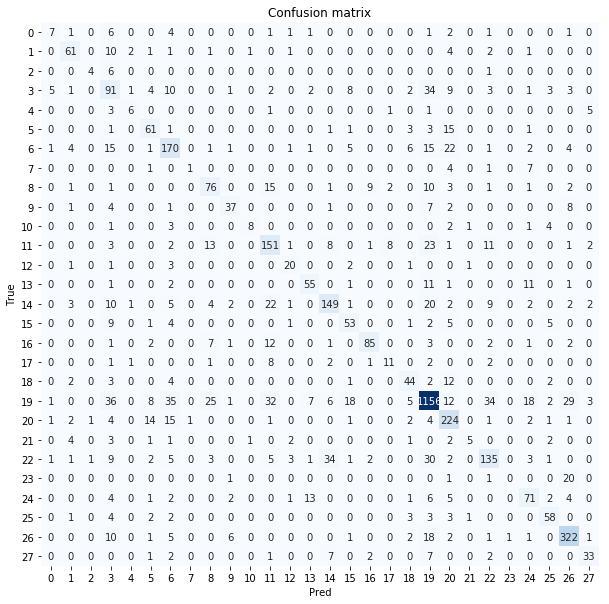

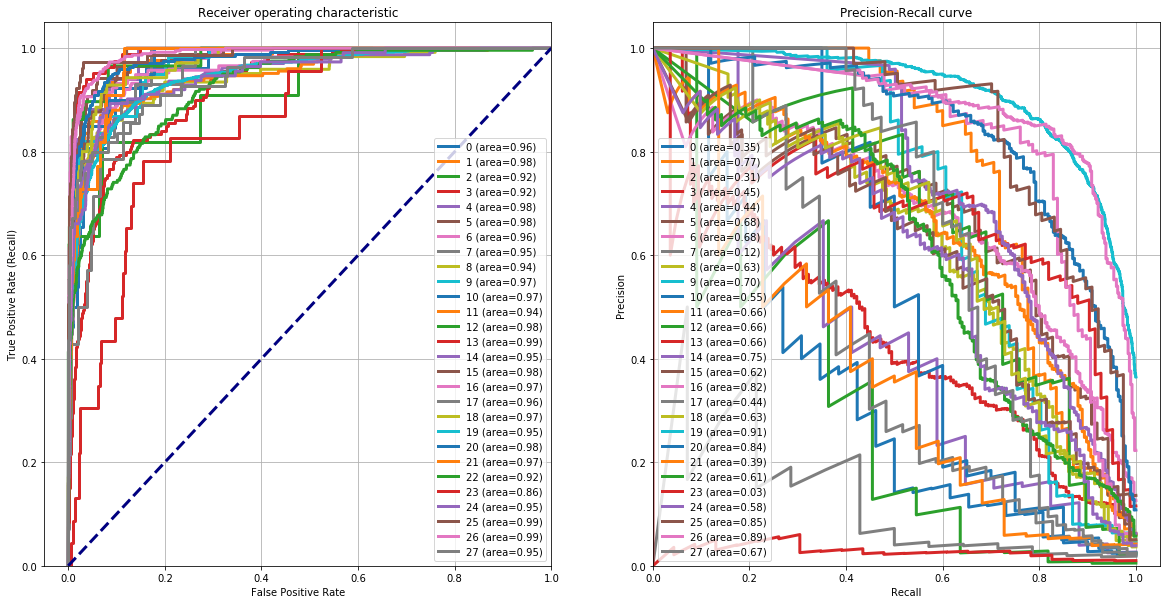

In [30]:
naive_bayes_Multinomial = naive_bayes.MultinomialNB(alpha=0.1)
naive_bayes_Multinomial.fit(X_count_train, y_count_train)

display_stats_model_trained(naive_bayes_Multinomial, X_count_train, y_count_train, X_count_test, y_count_test, True)

#### Entrainement du modèle avec ComplementNB

##### Avec le vectorizer Count

In [31]:
naive_bayes_Complement_count = naive_bayes.ComplementNB()

params = {
        'alpha': [0.001, 0.1, 0.25, 1.0, 10.0],
        'norm' : [True, False]
         }

naive_bayes_Complement_count_Grid = GridSearchCV(naive_bayes_Complement_count, param_grid=params, n_jobs=-1, cv=5, verbose=5)
naive_bayes_Complement_count_Grid.fit(X_count_train, y_count_train)

train_and_display_pipeline_results(naive_bayes_Complement_count_Grid, X_count_train, y_count_train, X_count_test, y_count_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 out of  50 | elapsed:    0.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Train Accuracy Best Estimator :  0.8744172661870504
Test Accuracy Best Estimator :  0.7207642725598526
Best Accuracy Through Grid Search :  0.7134388489208633
Best Parameters :  {'alpha': 1.0, 'norm': False}


##### Avec le vectorizer TF-IDF

In [32]:
naive_bayes_Complement_Tfidf = naive_bayes.ComplementNB()

params = {
        'alpha': [0.01,  0.1, 0.25, 1.0, 10.0],
        'norm' : [True, False]
         }

naive_bayes_Complement_Tfidf_Grid = GridSearchCV(naive_bayes_Complement_Tfidf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
naive_bayes_Complement_Tfidf_Grid.fit(X_Tfidf_train, y_Tfidf_train)

train_and_display_pipeline_results(naive_bayes_Complement_Tfidf_Grid, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.2s remaining:    0.6s


Train Accuracy Best Estimator :  0.8877697841726618
Test Accuracy Best Estimator :  0.7244475138121547
Best Accuracy Through Grid Search :  0.7175251798561151
Best Parameters :  {'alpha': 0.25, 'norm': False}


[Parallel(n_jobs=-1)]: Done  24 out of  50 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished


On obtient le meilleur résultat sur la base du vectorizer `TF-IDF`.

On affiche les métriques et graphiques pour ce vectorizer et avec les meilleurs hyperparamètres :

Accuracy:
Train:  0.8877697841726618
Test:  0.7244475138121547

Detail:
              precision    recall  f1-score   support

           0       0.52      0.42      0.47        26
           1       0.68      0.56      0.62        85
           2       0.64      0.82      0.72        11
           3       0.64      0.21      0.31       180
           4       0.70      0.41      0.52        17
           5       0.64      0.51      0.56        87
           6       0.72      0.64      0.68       250
           7       0.50      0.21      0.30        14
           8       0.70      0.61      0.66       122
           9       0.88      0.48      0.62        61
          10       0.56      0.25      0.34        20
          11       0.70      0.65      0.67       225
          12       0.64      0.62      0.63        29
          13       0.70      0.47      0.56        83
          14       0.68      0.72      0.70       235
          15       0.60      0.56      0.58        81
         

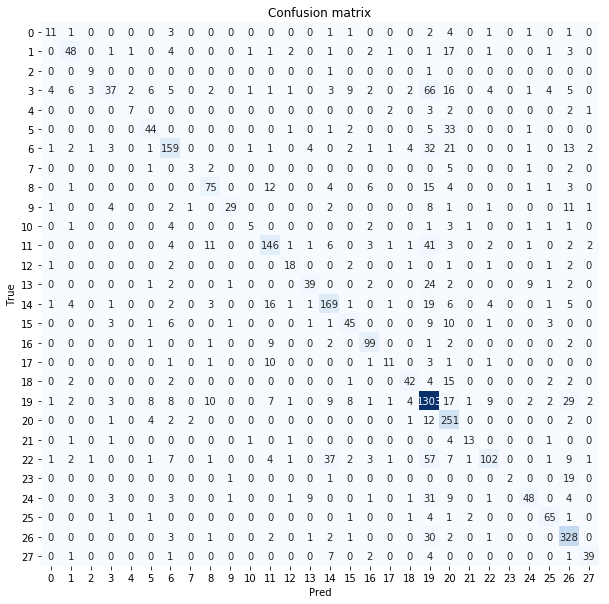

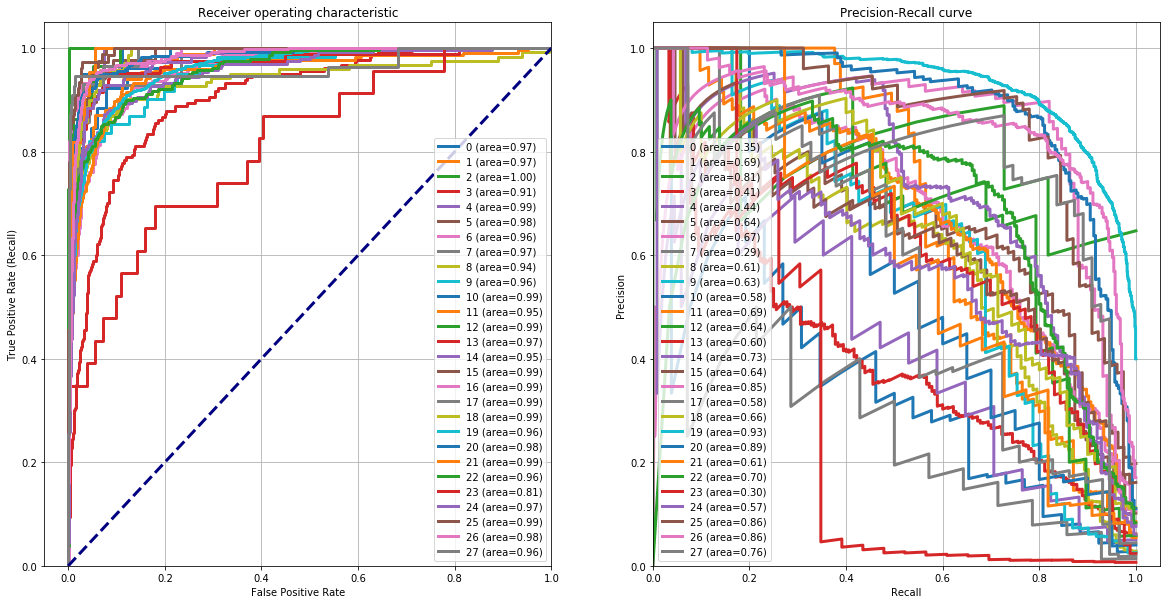

In [33]:
naive_bayes_Complement = naive_bayes.ComplementNB(alpha=0.25, norm=False)
naive_bayes_Complement.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(naive_bayes_Complement, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

#### Entrainement du modèle avec BernoulliNB

##### Avec le vectorizer Count

In [34]:
naive_bayes_Bernoulli_count = naive_bayes.BernoulliNB()

params = {
        'alpha': [0.001, 0.1, 0.25, 1.0, 10.0]
         }

naive_bayes_Bernoulli_count_Grid = GridSearchCV(naive_bayes_Bernoulli_count, param_grid=params, n_jobs=-1, cv=5, verbose=5)
naive_bayes_Bernoulli_count_Grid.fit(X_count_train, y_count_train)

train_and_display_pipeline_results(naive_bayes_Bernoulli_count_Grid, X_count_train, y_count_train, X_count_test, y_count_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.4s remaining:    0.2s


Train Accuracy Best Estimator :  0.8887482014388489
Test Accuracy Best Estimator :  0.6982044198895028
Best Accuracy Through Grid Search :  0.6874820143884892
Best Parameters :  {'alpha': 0.1}


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.7s finished


##### Avec le vectorizer TF-IDF

In [35]:
naive_bayes_Bernoulli_Tfidf = naive_bayes.BernoulliNB()

params = {
        'alpha': [0.01, 0.1, 0.25, 1.0, 10.0]
         }

naive_bayes_Bernoulli_Tfidf_Grid = GridSearchCV(naive_bayes_Bernoulli_Tfidf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
naive_bayes_Bernoulli_Tfidf_Grid.fit(X_Tfidf_train, y_Tfidf_train)

train_and_display_pipeline_results(naive_bayes_Bernoulli_Tfidf_Grid, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.3s remaining:    0.2s


Train Accuracy Best Estimator :  0.9031942446043165
Test Accuracy Best Estimator :  0.7186924493554327
Best Accuracy Through Grid Search :  0.7168920863309353
Best Parameters :  {'alpha': 0.01}


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.5s finished


On obtient le meilleur résultat sur la base du vectorizer `TF-IDF`.    

On affiche les métriques et graphiques pour ce vectorizer et avec les meilleurs hyperparamètres :

Accuracy:
Train:  0.9031942446043165
Test:  0.7186924493554327

Detail:
              precision    recall  f1-score   support

           0       0.55      0.46      0.50        26
           1       0.73      0.73      0.73        85
           2       0.83      0.45      0.59        11
           3       0.43      0.59      0.50       180
           4       0.39      0.71      0.50        17
           5       0.68      0.72      0.70        87
           6       0.61      0.72      0.66       250
           7       0.67      0.29      0.40        14
           8       0.59      0.55      0.57       122
           9       0.72      0.64      0.68        61
          10       0.67      0.60      0.63        20
          11       0.56      0.60      0.58       225
          12       0.70      0.66      0.68        29
          13       0.66      0.72      0.69        83
          14       0.73      0.56      0.64       235
          15       0.55      0.64      0.59        81
         

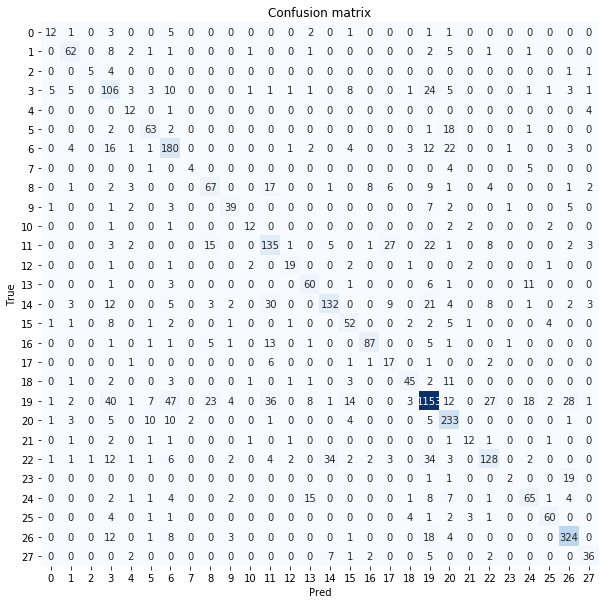

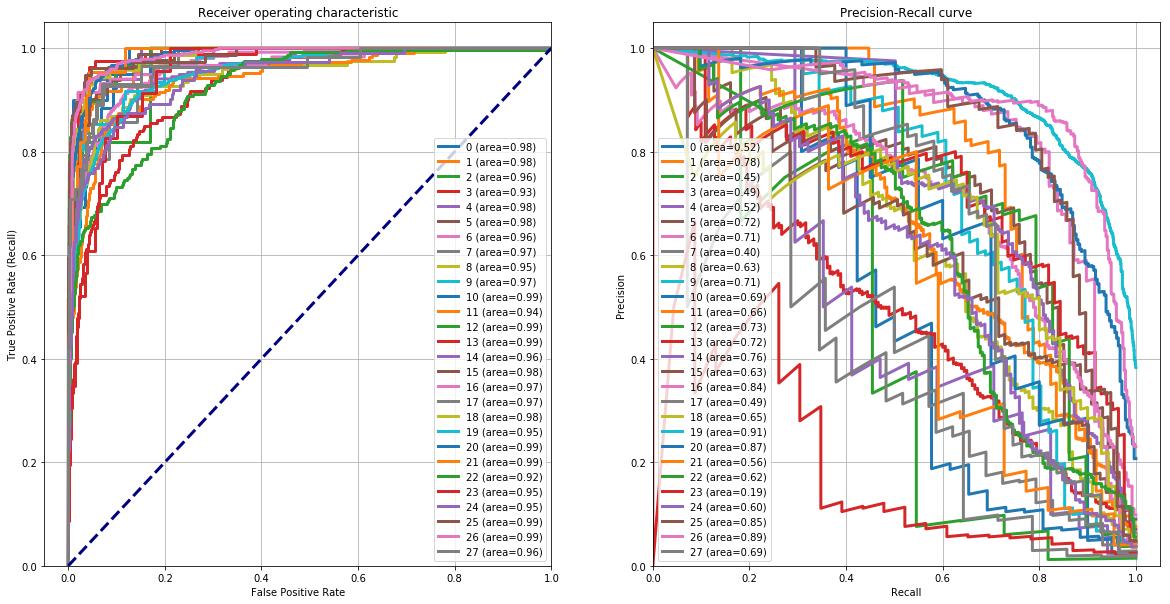

In [36]:
naive_bayes_Bernoulli = naive_bayes.BernoulliNB(alpha=0.01)
naive_bayes_Bernoulli.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(naive_bayes_Bernoulli, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

### Entrainement du modèle avec le classifier Random Forest

##### Avec le vectorizer Count

In [37]:
randomForest_count= RandomForestClassifier()

params = {
        'n_estimators': [100, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [100, 500]
         }

randomForest_count_Grid = GridSearchCV(randomForest_count, param_grid=params, n_jobs=-1, cv=5, verbose=5)
randomForest_count_Grid.fit(X_count_train, y_count_train)

train_and_display_pipeline_results(randomForest_count_Grid, X_count_train, y_count_train, X_count_test, y_count_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.3s
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by

Train Accuracy Best Estimator :  1.0
Test Accuracy Best Estimator :  0.6912983425414365
Best Accuracy Through Grid Search :  0.6812661870503597
Best Parameters :  {'max_depth': 500, 'max_features': 'sqrt', 'n_estimators': 500}


##### Avec le vectorizer TF-IDF

In [38]:
randomForest_Tdidf= RandomForestClassifier()

params = {
        'n_estimators': [100, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [100, 500]
         }

randomForest_Tfidf_Grid = GridSearchCV(randomForest_Tdidf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
randomForest_Tfidf_Grid.fit(X_Tfidf_train, y_Tfidf_train)

train_and_display_pipeline_results(randomForest_Tfidf_Grid, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.0s
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by

Train Accuracy Best Estimator :  1.0
Test Accuracy Best Estimator :  0.7156998158379374
Best Accuracy Through Grid Search :  0.7048057553956835
Best Parameters :  {'max_depth': 500, 'max_features': 'sqrt', 'n_estimators': 500}


On obtient le meilleur résultat sur la base du vectorizer `TF-IDF`.    

On affiche les métriques et graphiques pour ce vectorizer et avec les meilleurs hyperparamètres :

Accuracy:
Train:  1.0
Test:  0.7180018416206262

Detail:
              precision    recall  f1-score   support

           0       0.67      0.23      0.34        26
           1       0.88      0.52      0.65        85
           2       0.50      0.18      0.27        11
           3       0.57      0.27      0.36       180
           4       0.67      0.24      0.35        17
           5       0.86      0.63      0.73        87
           6       0.66      0.59      0.63       250
           7       0.75      0.21      0.33        14
           8       0.80      0.57      0.67       122
           9       0.97      0.48      0.64        61
          10       0.86      0.30      0.44        20
          11       0.75      0.64      0.69       225
          12       0.86      0.62      0.72        29
          13       0.79      0.23      0.36        83
          14       0.88      0.69      0.78       235
          15       0.81      0.62      0.70        81
          16       0.94 

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


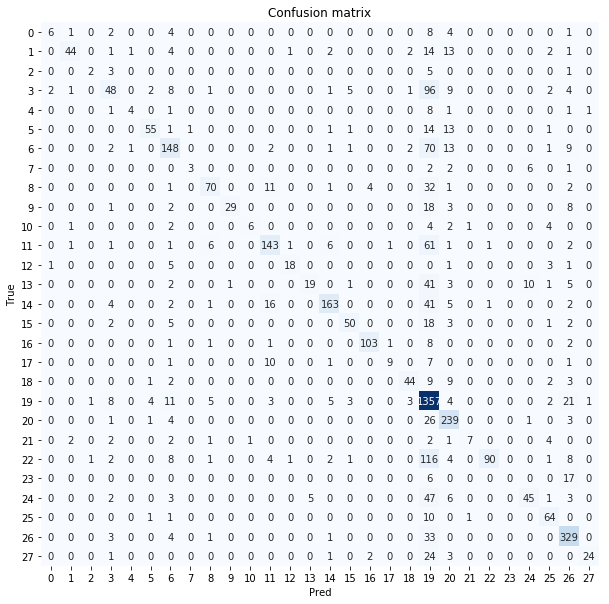

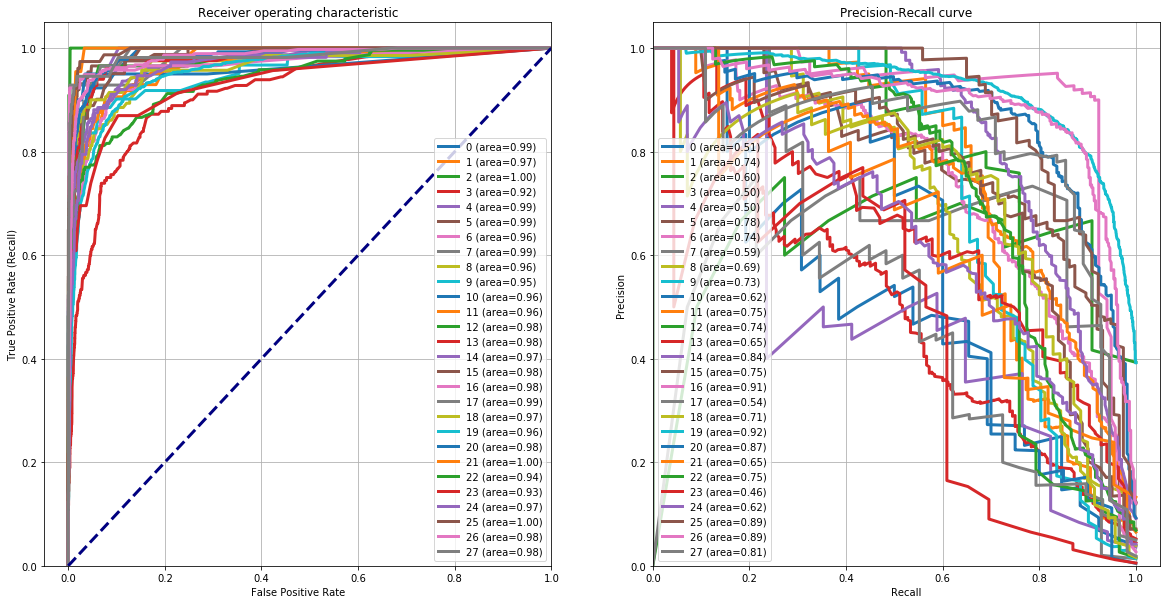

In [42]:
radom_forest_Tfidf = RandomForestClassifier(max_depth=500, max_features='sqrt', n_estimators= 500)
radom_forest_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(radom_forest_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

### Entrainement du modèle avec le classifier KNN

##### Avec le vectorizer Count

In [43]:
kNeighbors_count= KNeighborsClassifier()

params = {
        'n_neighbors': [3, 4, 5],
        'weights': ['uniform', 'distance']
         }

kNeighbors_count_Grid = GridSearchCV(kNeighbors_count, param_grid=params, n_jobs=-1, cv=5, verbose=5)
kNeighbors_count_Grid.fit(X_count_train, y_count_train)

train_and_display_pipeline_results(kNeighbors_count_Grid, X_count_train, y_count_train, X_count_test, y_count_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:   33.8s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   43.7s finished


Train Accuracy Best Estimator :  1.0
Test Accuracy Best Estimator :  0.5566298342541437
Best Accuracy Through Grid Search :  0.5588489208633094
Best Parameters :  {'n_neighbors': 5, 'weights': 'distance'}


##### Avec le vectorizer TF-IDF

In [45]:
kNeighbors_Tfidf= KNeighborsClassifier()

params = {
        'n_neighbors': [3, 4, 5],
        'weights': ['uniform', 'distance']
         }

kNeighbors_Tfidf_Grid = GridSearchCV(kNeighbors_Tfidf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
kNeighbors_Tfidf_Grid.fit(X_Tfidf_train, y_Tfidf_train)

train_and_display_pipeline_results(kNeighbors_Tfidf_Grid, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:   35.7s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   46.8s finished


Train Accuracy Best Estimator :  1.0
Test Accuracy Best Estimator :  0.6443370165745856
Best Accuracy Through Grid Search :  0.6455827338129496
Best Parameters :  {'n_neighbors': 5, 'weights': 'distance'}


On obtient le meilleur résultat sur la base du vectorizer `TF-IDF`.    

On affiche les métriques et graphiques pour ce vectorizer et avec les meilleurs hyperparamètres :

Accuracy:
Train:  1.0
Test:  0.6443370165745856

Detail:
              precision    recall  f1-score   support

           0       0.33      0.15      0.21        26
           1       0.82      0.48      0.61        85
           2       0.60      0.82      0.69        11
           3       0.40      0.09      0.15       180
           4       0.67      0.47      0.55        17
           5       0.60      0.45      0.51        87
           6       0.65      0.35      0.46       250
           7       0.17      0.07      0.10        14
           8       0.65      0.56      0.60       122
           9       0.70      0.31      0.43        61
          10       1.00      0.20      0.33        20
          11       0.67      0.61      0.64       225
          12       0.68      0.59      0.63        29
          13       0.62      0.28      0.38        83
          14       0.68      0.67      0.68       235
          15       0.70      0.37      0.48        81
          16       0.86 

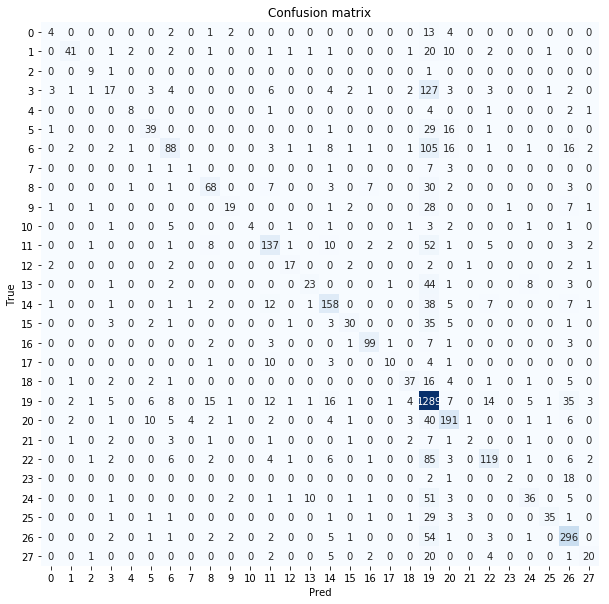

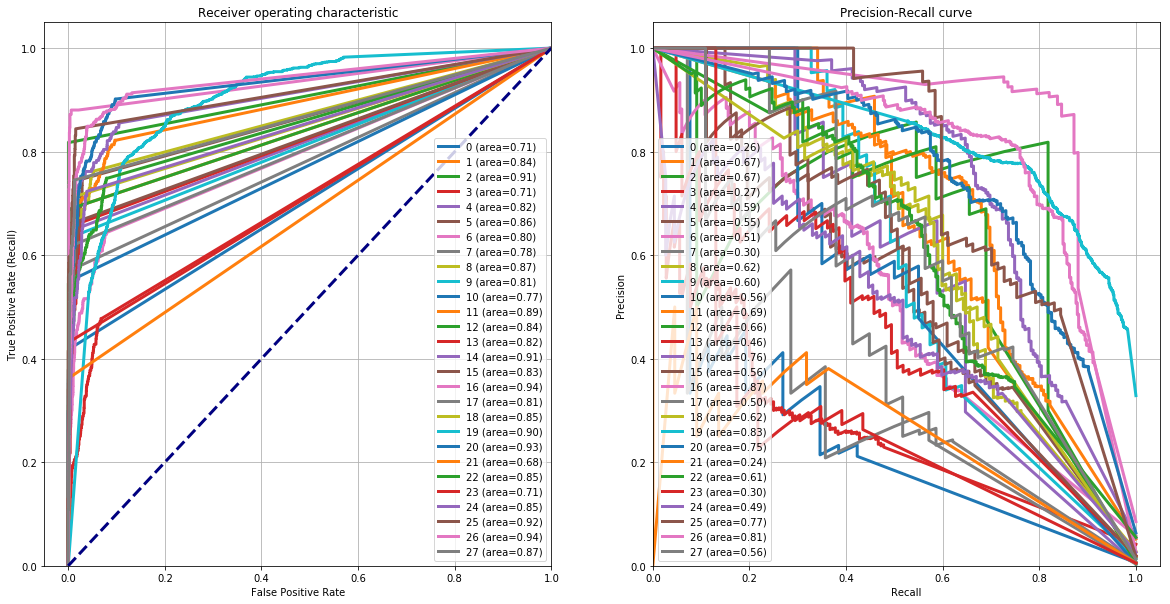

In [46]:
KNN_Tfidf = KNeighborsClassifier(n_neighbors=5, weights='distance')
KNN_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(KNN_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

### Entrainement du modèle avec le classifier Neural Network

Pour des raisons de ressources matérielles à notre disposition, nous n'avons pas pu mettre en place une pipeline pour ce type de classifier. En effet, le nombre d'hyperparamètres étant important, la pipeline prenait un temps trop conséquent. L'étude se fera donc en pas à pas sur ce modèle.

##### Avec le vectorizer Count

On utilise ici le solver `lbgs` qui a pour propriété de converger plus vite. Il est également plus adapté pour des petits datasets de données contrairement aux deux autres `adam` et `sgd`. On commence avec **2 layers de 20 neurones**, un **alpha** correspondant à la pénalisation de **1** et un **maximum d'itération égal à 5000**.

Accuracy:
Train:  1.0
Test:  0.7140883977900553

Detail:
              precision    recall  f1-score   support

           0       0.32      0.23      0.27        26
           1       0.62      0.60      0.61        85
           2       0.70      0.64      0.67        11
           3       0.47      0.46      0.46       180
           4       0.70      0.41      0.52        17
           5       0.60      0.60      0.60        87
           6       0.64      0.61      0.62       250
           7       0.47      0.50      0.48        14
           8       0.62      0.59      0.61       122
           9       0.56      0.57      0.56        61
          10       0.45      0.25      0.32        20
          11       0.64      0.69      0.67       225
          12       0.59      0.59      0.59        29
          13       0.54      0.60      0.57        83
          14       0.77      0.74      0.75       235
          15       0.60      0.54      0.57        81
          16       0.85 

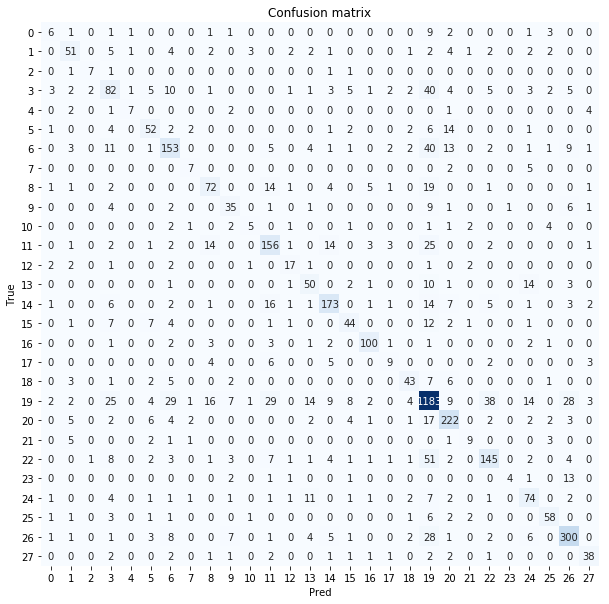

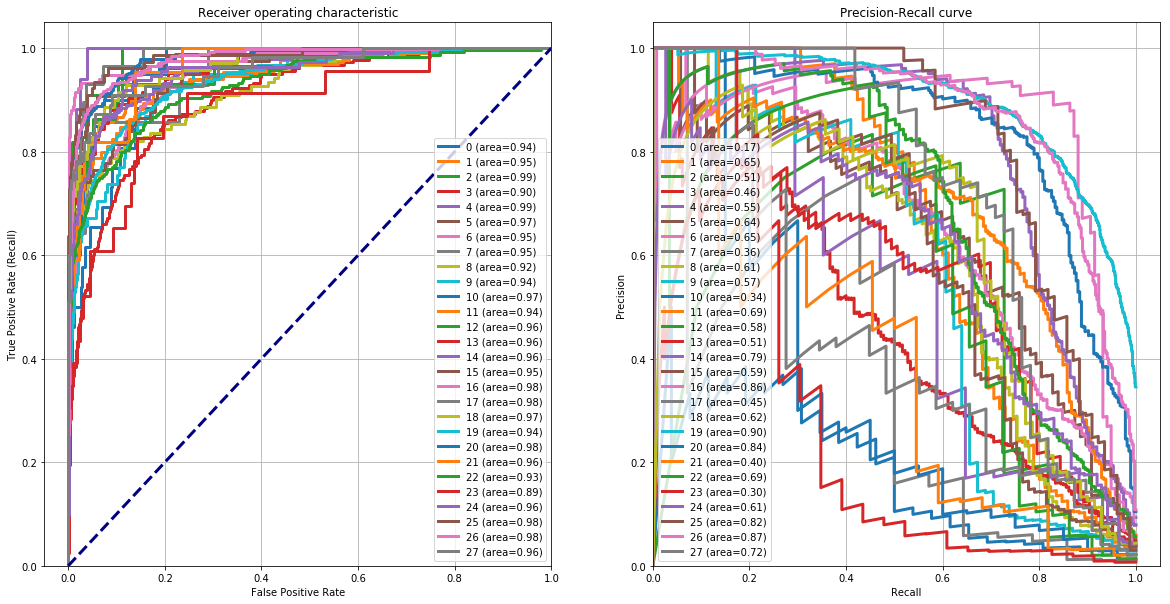

In [47]:
nn_count = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(20,20), alpha=1, activation="relu", max_iter=5000, random_state=0)
nn_count.fit(X_count_train, y_count_train)

display_stats_model_trained(nn_count, X_count_train, y_count_train, X_count_test, y_count_test, True)

##### Avec le vectorizer TF-IDF

On reprend les mêmes hyperparamètres pour l'entrainement du modèle basé sur le vectorizer `TF-IDF`.

Accuracy:
Train:  1.0
Test:  0.7168508287292817

Detail:
              precision    recall  f1-score   support

           0       0.42      0.19      0.26        26
           1       0.65      0.68      0.67        85
           2       0.70      0.64      0.67        11
           3       0.48      0.45      0.46       180
           4       0.50      0.47      0.48        17
           5       0.65      0.55      0.60        87
           6       0.63      0.62      0.63       250
           7       0.42      0.36      0.38        14
           8       0.62      0.51      0.56       122
           9       0.70      0.51      0.59        61
          10       0.67      0.40      0.50        20
          11       0.66      0.70      0.68       225
          12       0.76      0.66      0.70        29
          13       0.57      0.53      0.55        83
          14       0.80      0.73      0.76       235
          15       0.58      0.54      0.56        81
          16       0.91 

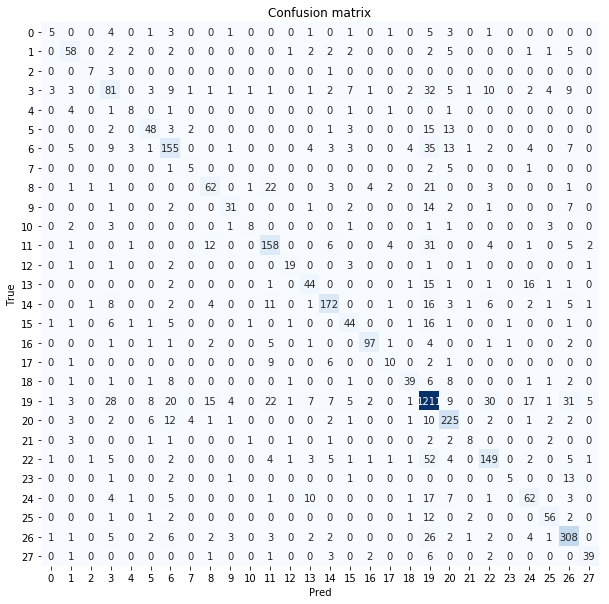

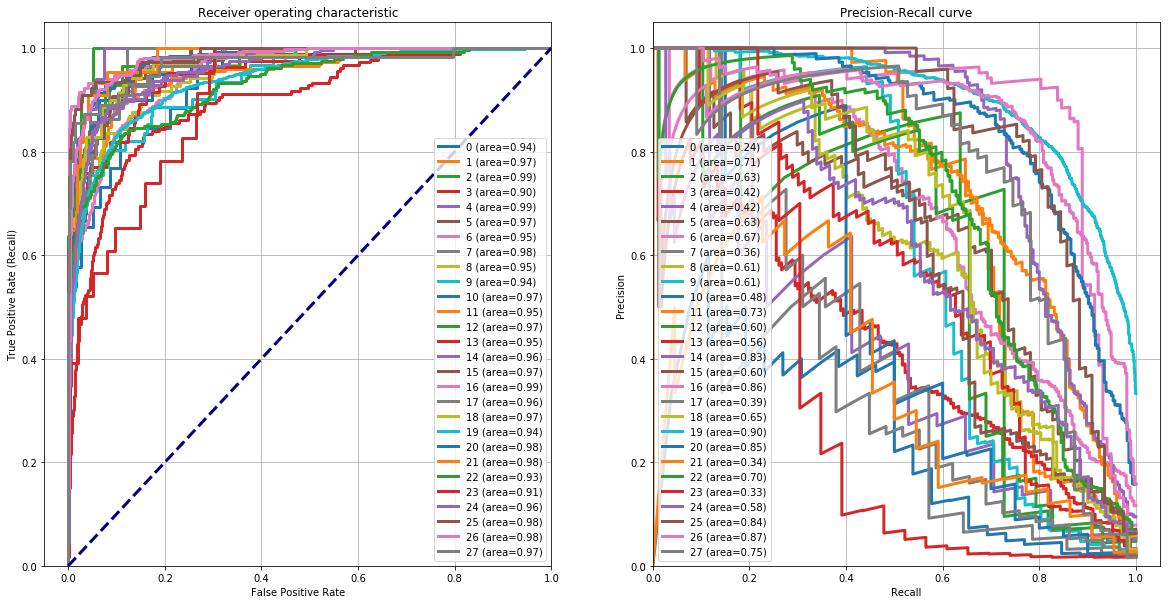

In [48]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(20,20), alpha=1, activation="relu", max_iter=5000, random_state=0)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

Les deux scores obtenus pour les vectorizers `TF-IDF` et `Count` sont sensiblement les mêmes. Avec les autres algorithmes, on a pu observer que les résultats associés au vectorizer `TF-IDF` étaient meilleurs que ceux de `Count`. Pour la suite, on prendra donc le dataset issue du vectorizer `TF-IDF`.  

On note un **overfitting** important du modèle qui est déjà corrigé par le paramètre `alpha`. En effet, nous avons testé pour des valeurs de `alpha` (pénalisation) plus basses et les résultats était très mauvais. 

##### Avec le vectorizer TF-IDF et un changement des layers

A présent, on teste le modèle avec une layer de 50 neurones. Le résultat de test obtenu est meilleur que précédemment.

In [49]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(50), alpha=1, activation="relu", max_iter=5000, random_state=0)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, False)

Accuracy:
Train:  1.0
Test:  0.7474677716390423



##### Avec le vectorizer TF-IDF et un changement du nombre de neurones pour la layer

On augmente le nombre de neurones pour la seule  layer du modèle. Aucune variation du score de test n'est constatée (légère baisse), on abandonne donc cette perspective (testé également pour 150 et 200).

In [29]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(500), alpha=1, activation="relu", max_iter=5000, random_state=0)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, False)

Accuracy:
Train:  0.9999424460431655
Test:  0.7430939226519337



##### Avec le vectorizer TF-IDF et un changement du nombre de neurones pour la layer et du alpha

On repasse le nombre de neurones pour la layer à 50 car le résultat était meilleur pour cette valeur. On augmente également la pénalisation qui permet une hausse de la précision des valeurs de test.

Accuracy:
Train:  0.9995971223021582
Test:  0.7509208103130756

Detail:
              precision    recall  f1-score   support

           0       0.55      0.23      0.32        26
           1       0.78      0.66      0.71        85
           2       0.86      0.55      0.67        11
           3       0.46      0.48      0.47       180
           4       0.82      0.53      0.64        17
           5       0.75      0.69      0.72        87
           6       0.63      0.68      0.66       250
           7       0.67      0.29      0.40        14
           8       0.73      0.60      0.66       122
           9       0.78      0.57      0.66        61
          10       0.82      0.45      0.58        20
          11       0.69      0.76      0.72       225
          12       0.76      0.66      0.70        29
          13       0.59      0.57      0.58        83
          14       0.80      0.77      0.78       235
          15       0.77      0.63      0.69        81
         

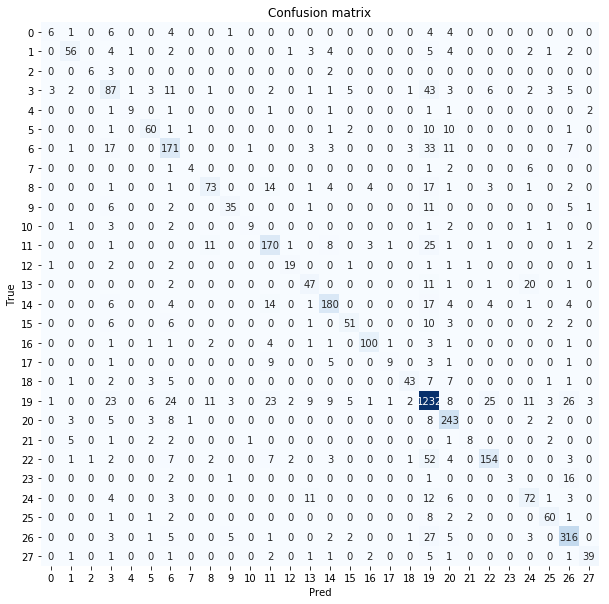

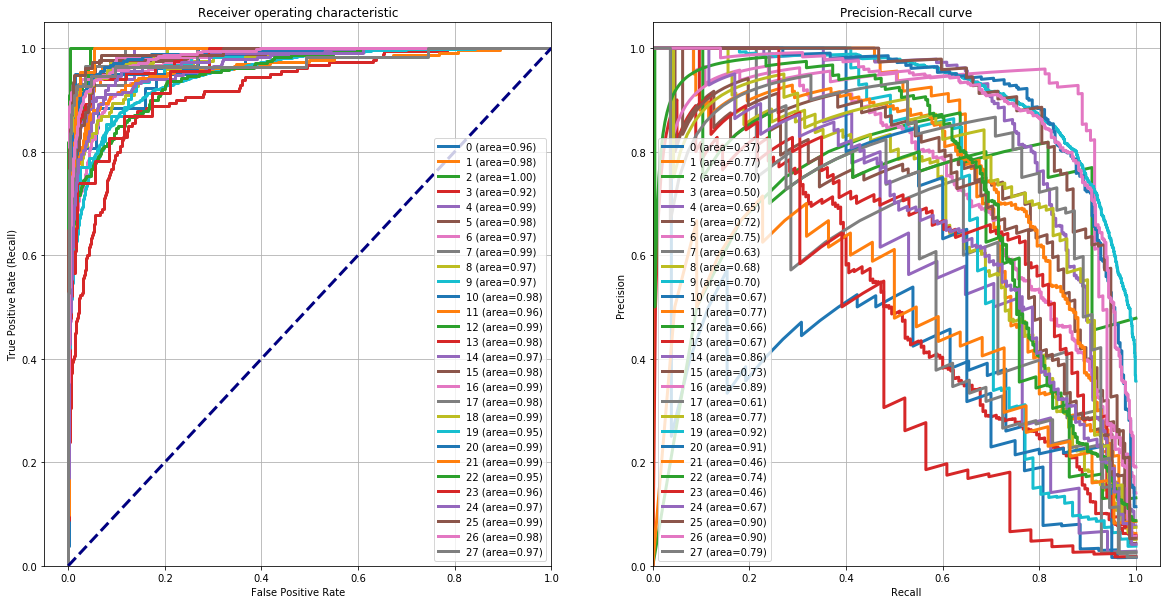

In [30]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(50), alpha=3, activation="relu", max_iter=5000, random_state=0)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

##### Avec le vectorizer TF-IDF et un changement de la fonction d'activation

Après changement de la fonction d'activation de `relu` à `tanh`, le résultat obtenu devient moins précis.

In [31]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(50), alpha=3, activation="tanh", max_iter=5000, random_state=0)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, False)

Accuracy:
Train:  0.9993669064748202
Test:  0.7430939226519337



##### Avec le vectorizer TF-IDF et de la fonction d'activation

Après avoir essayer le fonction d'activation `tanh`, on tente maintement le fonction `logistic`. Il n'y a pas d'améliorations.

In [32]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(50), alpha=3, activation="logistic", max_iter=1000)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, False)

Accuracy:
Train:  0.9334676258992806
Test:  0.7474677716390423



##### Avec le vectorizer TF-IDF et changement de la fonction d'activation

De même avec la fonction `identity`.

In [33]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(50), alpha=3, activation="identity", max_iter=1000)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, False)

Accuracy:
Train:  0.9994244604316547
Test:  0.7430939226519337



##### Avec le vectorizer TF-IDF et changement du learning rate

On tente une augmentation de la valeur du `learning_rate`, cependant le score devient moins précis.

In [34]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(50), alpha=3, activation="relu", max_iter=1000, learning_rate= "adaptive")
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, False)

Accuracy:
Train:  0.9995971223021582
Test:  0.7488489871086557



##### Avec le vectorizer TF-IDF et changement du solver

On réalise un changement du solver pour vérifier nos propos en début de partie. Le changement est réalisé seulement pour le solver `adam`, car il est décrit comme une version optimisée du solver `sgd` dans la documentation.

Accuracy:
Test:  0.4661602209944751
Train:  0.47522302158273383
Detail:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        85
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00       180
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00        87
           6       0.00      0.00      0.00       250
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00       122
           9       0.00      0.00      0.00        61
          10       0.00      0.00      0.00        20
          11       0.55      0.18      0.27       225
          12       0.00      0.00      0.00        29
          13       0.00      0.00      0.00        83
          14       0.59      0.62      0.60       235
          15       0.00      0.00      0.00        81
         

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


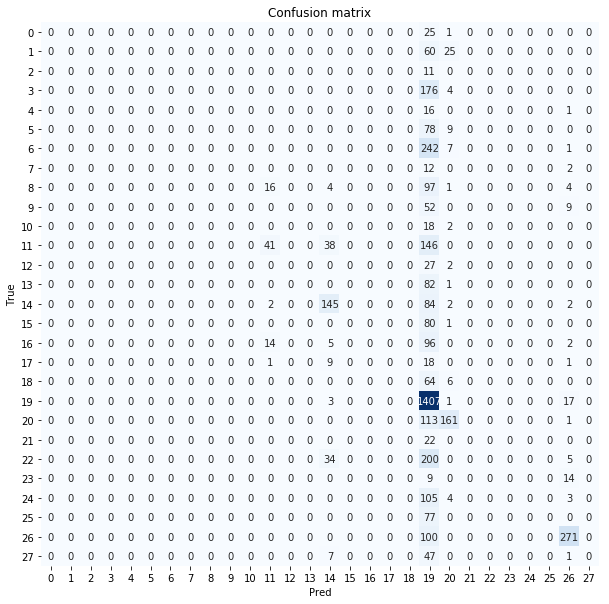

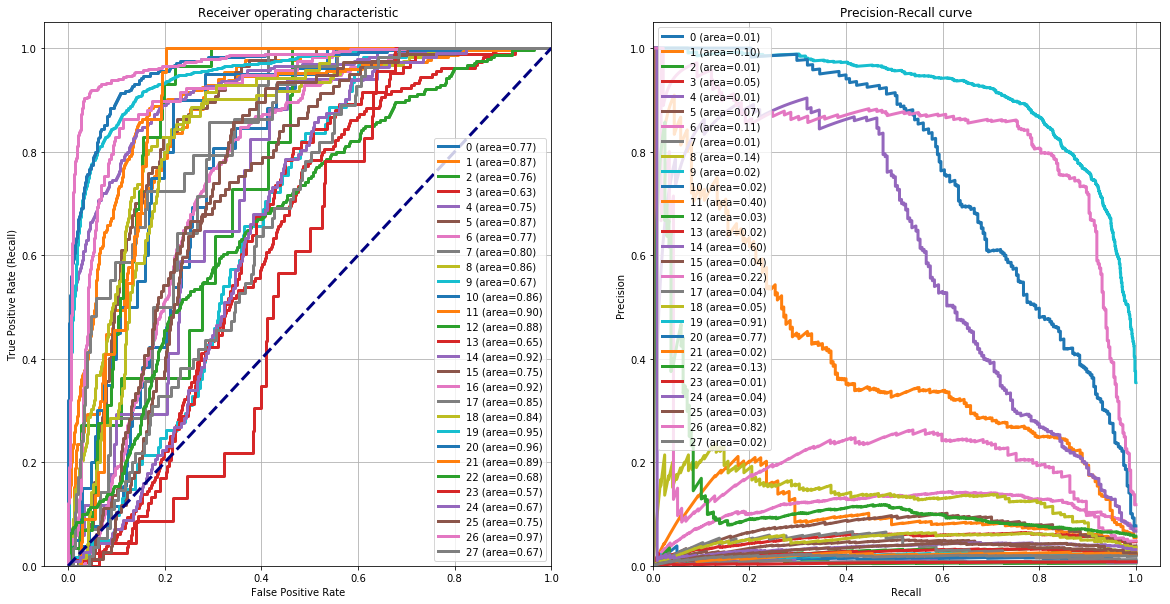

In [33]:
nn_Tfidf = MLPClassifier(solver="adam", hidden_layer_sizes=(50), alpha=3, activation="relu", max_iter=1000)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, False)

##### Conclusion sur le Neural Network Classifier

Le meilleur score pour ce modèle est obtenu avec les hyperparamètres suivants : `solver="lbfgs"`, `hidden_layer_sizes=(50)`, `alpha=3`, `activation="relu"` et `max_iter=5000`.

### Conlusion

A la suite de toutes ses expérimentations, les algorithmes de la famille **Naives Bayes** donnent des résultats plutôt encourageants : la précision maximale de *0.72* est atteinte pour l'un d'entre eux. On note aussi que la convergence est très rapide pour ce type d'algorithme et ce facteur est à prendre à compte pour notre modèle final.

Pour l'algorithme **RandomTree**, les scores obtenus sont un peu plus faibles, ce modèle ne sera donc pas retenu.

Le **KNN** propose lui aussi un manque de précision pour notre application.

Pour finir, le **Neural Network** est le modèle avec le meilleur score. Le précision pour le test atteint les *0.75* pour une liste d'hyperparamètres. Il s'agit du modèle le plus prometteur, car il est possible de faire encore évoluer ces paramètres.

### Tentative pipeline classifier Neural Network

Cette dernière partie représente juste la tentative de pipeline pour le NN classifier.   

Lancé sur AWS, le système a réalisé un `kill -9` après environ 5 heures de calculs...

In [56]:
from sklearn.model_selection import GridSearchCV

parameter_space = {
    'hidden_layer_sizes': [(50,)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs'],
    'alpha': [1, 0.1],
    'learning_rate': ['constant','adaptive'],
}

In [57]:
mlp = MLPClassifier(max_iter=1000)
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_Tfidf_train, y_Tfidf_train)

train_and_display_pipeline_results(kNeighbors_count_Grid, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test)

exception calling callback for <Future at 0x7f91ad291320 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/ec2-us

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}